# Test Trotterization on FakeJakarta with QREM

- Status: OK

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_28700/4110962823.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Trotter Gate

In [7]:
def trotter_gate(dt, to_instruction = True):
    qc = QuantumCircuit(2)
    qc.rx(2 * dt, 0)
    qc.rz(2 * dt, 1)
    qc.h(1)
    qc.cx(1, 0)
    qc.rz(-2 * dt, 0)
    qc.rx(-2 * dt, 1)
    qc.rz(2 * dt, 1)
    qc.cx(1, 0)
    qc.h(1)
    qc.rz(2 * dt, 0)
    return qc.to_instruction() if to_instruction else qc

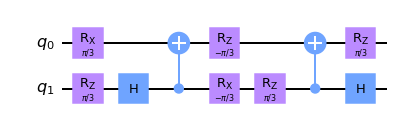

In [8]:
trotter_gate(np.pi / 6, to_instruction=False).draw("mpl")

# Initial State Function

In [9]:
def make_initial_state(qc, initial_state):
    """
    logical qubit index
    little endian
    """
    for i, state in enumerate(initial_state):
        if state == "1":
            qc.x(i)

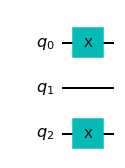

In [10]:
qc = QuantumCircuit(3)
make_initial_state(qc, "101")
qc.draw("mpl")

# エンコーダとデコーダ

論理|q_0, q_1, q_2>を、論理|q_1, q_2>にエンコード

エンコードするときに、q_0が1を保っていれば、デコードの際にcnotが1個減らせる？？→嘘

In [11]:
def subspace_encoder(qc, targets):
    """
    naive method, can be optimized for init state |110>
    little endian
    """
    n = qc.num_qubits
    qc.cx(targets[2],targets[1])
    qc.cx(targets[1],targets[0])

In [12]:
def subspace_encoder_init110(qc, targets):
    """
    optimized encoder for init state |110>
    endian: |q_0, q_1, q_2> (little endian)
    encode |110> to |0>|10>
    """
    n = qc.num_qubits
    qc.x(targets[0])

In [13]:
def subspace_decoder(qc, targets):
    """
    naive method
    little endian
    """
    n = qc.num_qubits
    qc.cx(targets[1], targets[0])
    qc.cx(targets[2], targets[1])

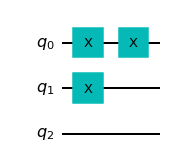

In [14]:
qc = QuantumCircuit(3)
make_initial_state(qc, "110")
subspace_encoder_init110(qc, targets=[0,1,2])
qc.draw("mpl")

# Trotterization Function

In [15]:
def trotterize(qc, trot_gate, num_steps, targets):
    for _ in range(num_steps):
        qc.append(trot_gate, qargs = targets)

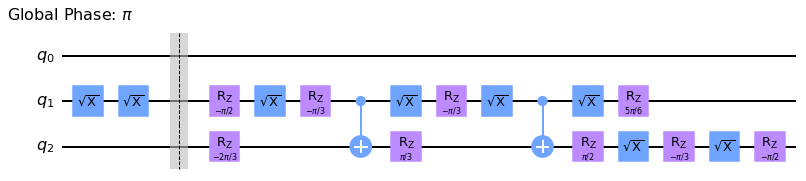

In [16]:
qc = QuantumCircuit(3)
make_initial_state(qc, "110")
subspace_encoder_init110(qc, targets=[0,1,2])
qc.barrier()
trotterize(qc, trotter_gate(np.pi / 6), 1, targets=[1, 2])
qc = transpile(qc, optimization_level = 3, basis_gates=["sx", "rz", "cx"])
qc.draw("mpl")

# Set Parameters

In [17]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Prepare Circuits

logical circuits = little endian
name: lq = logical qubits 

In [19]:
st_qcs_list = []
# Number of trotter steps
max_trotter_step = 50  ### CAN BE >= 4
trotter_steps = list(range(1, max_trotter_step + 1, 3))
for num_steps in trotter_steps:
    print("trotter step: ", num_steps)
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(num_qubits, name="lq")
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    make_initial_state(qc, "101")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    
    subspace_encoder(qc, targets=[0, 1, 2]) # encode
    trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
    subspace_decoder(qc, targets=[0,1,2]) # decode

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({dt: target_time / num_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
    
    # remove barriers
    st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
    
    # optimize circuit
    t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
    st_qcs_list.append(t3_st_qcs)

trotter step:  1
trotter step:  4
trotter step:  7
trotter step:  10
trotter step:  13
trotter step:  16
trotter step:  19
trotter step:  22
trotter step:  25
trotter step:  28
trotter step:  31
trotter step:  34
trotter step:  37
trotter step:  40
trotter step:  43
trotter step:  46
trotter step:  49


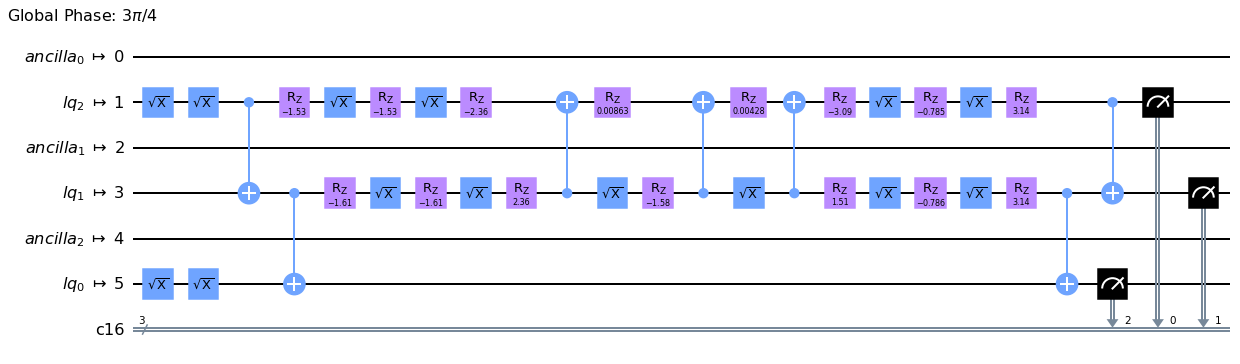

In [20]:
st_qcs_list[-1][-1].draw("mpl")

# Set Backend

In [21]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# print("provider:", provider)
# backend = provider.get_backend("ibmq_jakarta")

# Execute Circuits

In [22]:
jobs = []
shots = 1 << 13
# Number of trotter steps
for i, num_steps in enumerate(trotter_steps):
    print("trotter step: ", num_steps)
    # execute: reps = 1
    job = execute(st_qcs_list[i], backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)
    print()

trotter step:  1
Job ID 45aa9ee3-1131-4a12-ad57-f346b61fc3ba

trotter step:  4
Job ID 486e6f7f-f523-4147-b780-8e13948c0e19

trotter step:  7
Job ID 0b053b47-0ba4-46aa-aad3-77de96910e39

trotter step:  10
Job ID 510215eb-6c54-4099-8839-98d2bea70a26

trotter step:  13
Job ID 83ae8c4d-67e4-4a92-b079-e25dc6a809b8

trotter step:  16
Job ID 8896ee7d-edfe-49b3-8b93-1a2d17770626

trotter step:  19
Job ID 2b0e9043-2063-4e88-8bd2-b8068e8fa801

trotter step:  22
Job ID caa3edc8-a3c8-4c25-9dd3-830a3fd8ea9a

trotter step:  25
Job ID dd88f8e2-daa7-4c78-9892-0ed1669dda22

trotter step:  28
Job ID 6da6ed17-3cd9-4d44-81eb-584f5b6e4948

trotter step:  31
Job ID d80c1124-aa71-4380-9158-c59ee277a5ab

trotter step:  34
Job ID d51fcf93-9ed4-41b9-b1a9-26809b9e19a0

trotter step:  37
Job ID 12e07b33-24f7-48b1-b80d-97940b96fd0e

trotter step:  40
Job ID 2d4000b9-8a68-49db-ae22-159725f2244e

trotter step:  43
Job ID 03d363e2-aaee-4e62-aad6-0043b6f028ba

trotter step:  46
Job ID 2304ce87-ec84-4498-bbf9-7524605d3

# QREM

In [23]:
# QREM
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout = initial_layout)
print('Job ID', cal_job.job_id())

Job ID c726abea-6917-4791-af10-7b8b0483dd25


In [24]:
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [25]:
results = []
for job in jobs:
    results.append( job.result() )

In [26]:
mit_results = []
for job in jobs:
    mit_results.append( meas_fitter.filter.apply(job.result()) )

In [27]:
print(len(results), len(mit_results))

17 17


# State Tomography

In [32]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^Zero^One).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute Fidelity

In [33]:
# Compute tomography fidelities for each repetition
raw_fids = []
for result in results:
    fid = state_tomo(result, st_qcs)
    raw_fids.append(fid)
    
# print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

In [34]:
# Compute tomography fidelities for each repetition
fids = []
for result in mit_results:
    fid = state_tomo(result, st_qcs)
    fids.append(fid)
    
# print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

<Figure size 432x288 with 0 Axes>

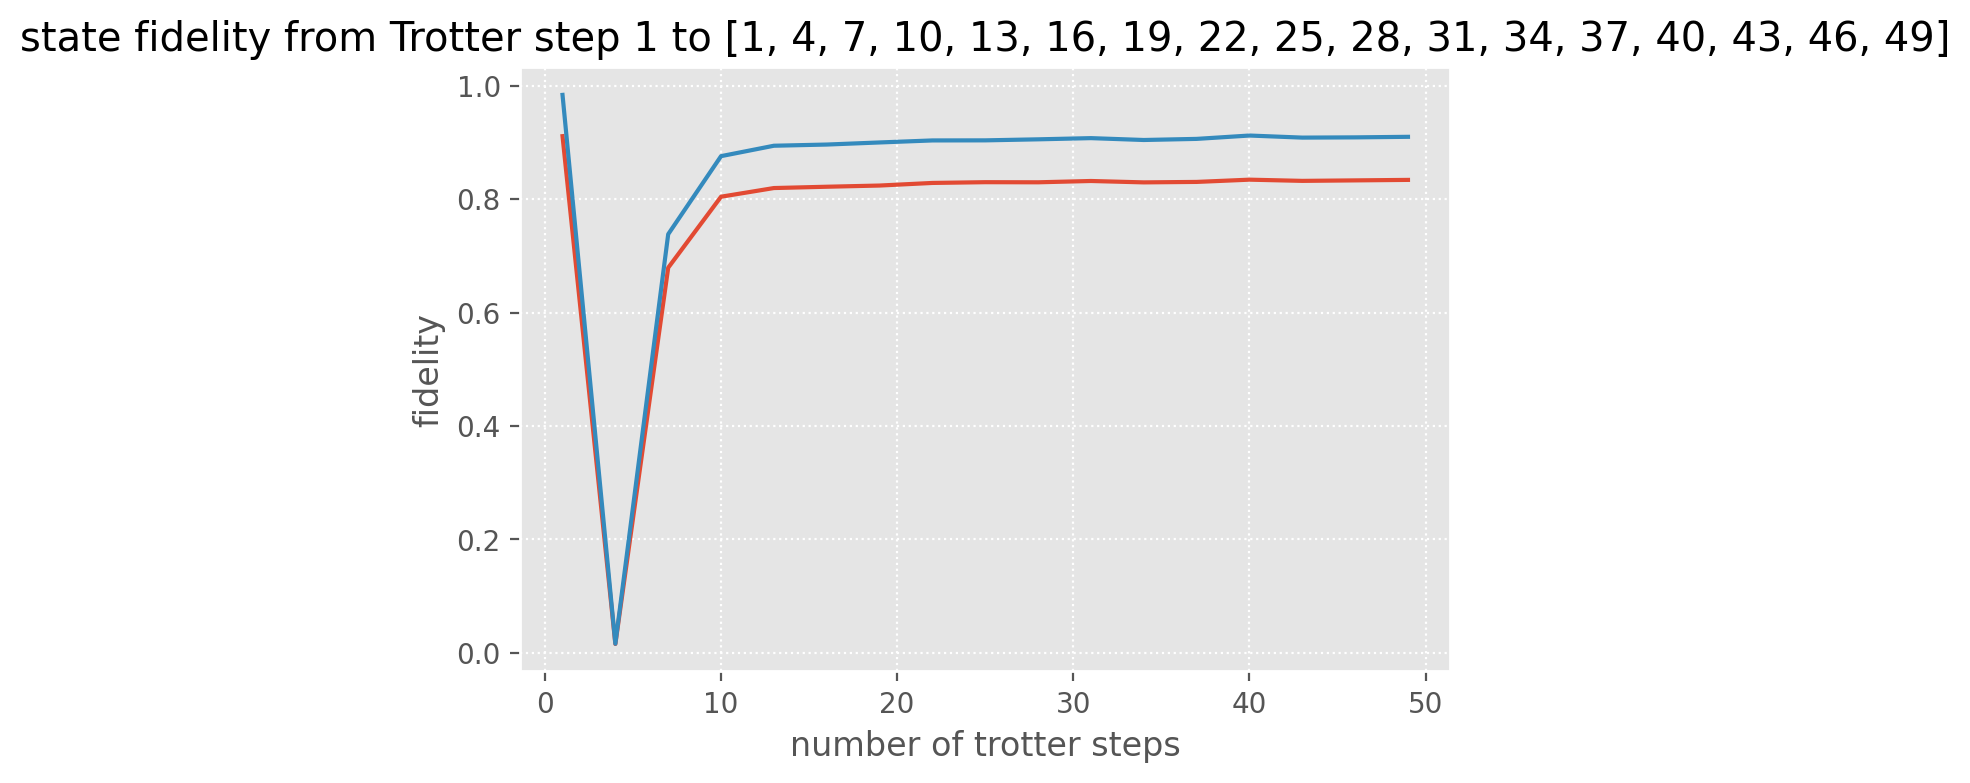

In [35]:
plt.clf()
plt.style.use('ggplot')
plt.figure(dpi=200)
plt.title("state fidelity from Trotter step 1 to "+str(trotter_steps))
plt.plot(trotter_steps, raw_fids, label="raw fidelity")
plt.plot(trotter_steps, fids, label="fidelity after QREM")
plt.xlabel("number of trotter steps")
plt.ylabel("fidelity")
plt.grid(linestyle='dotted')

In [36]:
for step, fid in zip(trotter_steps, raw_fids):
    print(step, fid)

1 0.9111667026289626
4 0.015382122555370149
7 0.6791192609505274
10 0.8043591810247157
13 0.8196312368112191
16 0.8219456457087722
19 0.8240497935863766
22 0.8286399596885939
25 0.8299668238306871
28 0.8297713005002499
31 0.8320833522549236
34 0.8296285858462835
37 0.8304414341516956
40 0.8344114758966658
43 0.8322854669965384
46 0.8331499530217008
49 0.8340108432423502


In [37]:
for step, fid in zip(trotter_steps, fids):
    print(step, fid)

1 0.9839395974015981
4 0.015897898510546744
7 0.7382239626128412
10 0.8759005239775361
13 0.894266656617119
16 0.8963578529882205
19 0.9000504998129404
22 0.9036162330076629
25 0.9037577411565886
28 0.905569970866464
31 0.907677233713221
34 0.9043924621829968
37 0.9063446955257554
40 0.9122592429535616
43 0.9085986695891071
46 0.9090259706333267
49 0.9099958319334812
